# Chemical Kinetics

Chemical Kinetics Example for JAXSR.

Demonstrates discovering rate laws from kinetic data, including:
- Langmuir-Hinshelwood kinetics
- Power law kinetics
- Arrhenius temperature dependence

In [1]:
import jax.numpy as jnp
import numpy as np
from jaxsr import BasisLibrary, Constraints, SymbolicRegressor

## Discover Langmuir-Hinshelwood rate law.

True model:

$$r = \frac{k\,C_A\,C_B}{1 + K\,C_A}, \quad k=2.5,\; K=1.2$$

In [2]:
# Generate synthetic kinetic data
np.random.seed(42)
n_samples = 100

# Concentration ranges typical for catalytic reactions
C_A = np.random.uniform(0.1, 2.0, n_samples)
C_B = np.random.uniform(0.1, 2.0, n_samples)

# True kinetic parameters
k = 2.5  # Rate constant
K = 1.2  # Adsorption equilibrium constant

# True rate law
r_true = k * C_A * C_B / (1 + K * C_A)
r = r_true + np.random.randn(n_samples) * 0.05

X = jnp.column_stack([C_A, C_B])
y = jnp.array(r)

print("\nTrue model: r = 2.5*C_A*C_B / (1 + 1.2*C_A)")
print(f"Data: {n_samples} samples")

# Build basis library with appropriate functions for kinetics
library = (
    BasisLibrary(n_features=2, feature_names=["C_A", "C_B"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_interactions(max_order=2)
    .add_ratios()
    .add_transcendental(["inv"])
)

print(f"Basis library: {len(library)} candidate functions")

# Add constraint: reaction rate must be non-negative
constraints = Constraints().add_bounds("y", lower=0)

# Fit model
model = SymbolicRegressor(
    basis_library=library,
    max_terms=6,
    strategy="greedy_forward",
    information_criterion="bic",
    constraints=constraints,
)
model.fit(X, y)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print("\nMetrics:")
print(f"  R² = {model.metrics_['r2']:.4f}")
print(f"  MSE = {model.metrics_['mse']:.6f}")


True model: r = 2.5*C_A*C_B / (1 + 1.2*C_A)
Data: 100 samples
Basis library: 10 candidate functions



Discovered expression:
  y = 0.4584*C_A*C_B + 0.7089*C_B - 0.0665*C_B/C_A - 0.1482*C_A^2 + 0.2811*C_A - 0.1014

Metrics:
  R² = 0.9930
  MSE = 0.003413


/var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/ipykernel_44192/2042090146.py:7: UserWarning: Constraints are active. Classical OLS intervals may not be valid. Consider using bootstrap methods instead.
  intervals = model.coefficient_intervals(alpha=0.05)


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
          C_A*C_B     0.4584    0.0252    18.19   0.00e+00 [0.4083, 0.5084] ***
              C_B     0.7089    0.0343    20.68   0.00e+00 [0.6408, 0.7769] ***
          C_B/C_A    -0.0665    0.0072    -9.21   8.66e-15 [-0.0808, -0.0522] ***
            C_A^2    -0.1482    0.0319    -4.64   1.13e-05 [-0.2116, -0.0848] ***
              C_A     0.2811    0.0696     4.04   1.11e-04 [0.1428, 0.4193] ***
                1    -0.1014    0.0362    -2.80   6.22e-03 [-0.1733, -0.0295] **
  --- *** p<0.001, ** p<0.01, * p<0.05


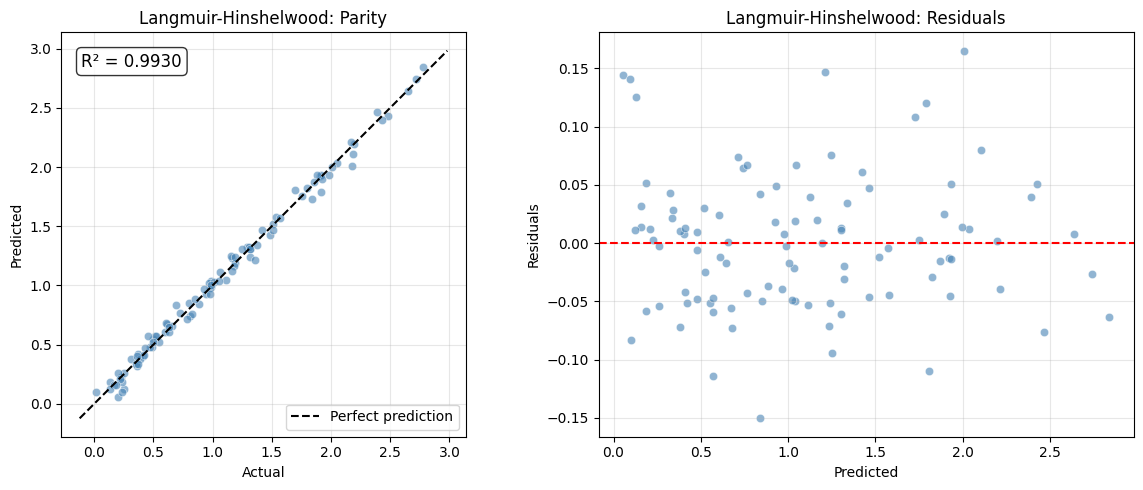


ANOVA Table (Langmuir-Hinshelwood)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  C_A*C_B                       1       39.6578       39.6578    10921.87      0.0000
  C_B                           1        7.3716        7.3716     2030.17      0.0000
  C_B/C_A                       1        1.1348        1.1348      312.51      0.0000
  C_A^2                         1        0.0194        0.0194        5.34      0.0231
  C_A                           1        0.0363        0.0363        9.99      0.0021
  1                             1        0.0284        0.0284        7.83      0.0062
  Model                         5       48.2483        9.6497     2657.54      0.0000
  Residual                     94        0.3413        0.0036                        
  Total                        99       48.5896        0.4908                        
-----------------------

In [3]:
# Parameter significance, diagnostics, and ANOVA
import matplotlib.pyplot as plt
from scipy import stats as sp_stats
from jaxsr import anova
from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Langmuir-Hinshelwood: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Langmuir-Hinshelwood: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Langmuir-Hinshelwood)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Discover power law kinetics.

True model:

$$r = 1.5\,C_A^{1.0}\,C_B^{0.5}$$

In [4]:
np.random.seed(42)
n_samples = 100

C_A = np.random.uniform(0.5, 3.0, n_samples)
C_B = np.random.uniform(0.5, 3.0, n_samples)

# True parameters
k = 1.5
a = 1.0  # First order in A
b = 0.5  # Half order in B

r_true = k * C_A**a * C_B**b
r = r_true + np.random.randn(n_samples) * 0.02

X = jnp.column_stack([C_A, C_B])
y = jnp.array(r)

print("\nTrue model: r = 1.5 * C_A^1.0 * C_B^0.5")

# For power law, include sqrt for half-order
library = (
    BasisLibrary(n_features=2, feature_names=["C_A", "C_B"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_interactions(max_order=2)
    .add_transcendental(["sqrt"])
)

# Add custom basis function for C_A * sqrt(C_B)
library.add_custom(
    name="C_A*sqrt(C_B)",
    func=lambda X: X[:, 0] * jnp.sqrt(X[:, 1]),
    complexity=2,
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
)
model.fit(X, y)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print(f"  R² = {model.metrics_['r2']:.4f}")


True model: r = 1.5 * C_A^1.0 * C_B^0.5



Discovered expression:
  y = 1.498*C_A*sqrt(C_B) + 0.002123*C_B^2
  R² = 0.9999


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
    C_A*sqrt(C_B)     1.4976    0.0014  1044.48   0.00e+00 [1.4947, 1.5004] ***
            C_B^2     0.0021    0.0008     2.73   7.60e-03 [0.0006, 0.0037] **
  --- *** p<0.001, ** p<0.01, * p<0.05


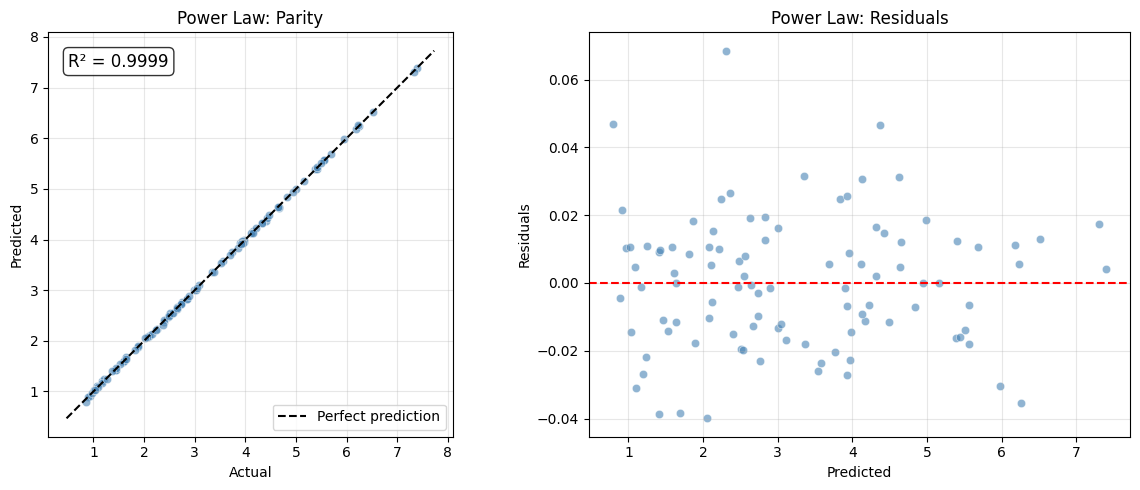


ANOVA Table (Power Law)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  C_A*sqrt(C_B)                 1      258.3101      258.3101   677889.05      0.0000
  C_B^2                         1        0.0028        0.0028        7.43      0.0076
  Model                         1      258.3129      258.3129   677896.48      0.0000
  Residual                     98        0.0373        0.0004                        
  Total                        99      258.3503        2.6096                        
--------------------------------------------------------------------------------

Variance Contributions:
  C_A*sqrt(C_B)               100.0%  ***
  C_B^2                         0.0%  **


In [5]:
# Parameter significance, diagnostics, and ANOVA
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Power Law: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Power Law: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Power Law)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Discover Arrhenius temperature dependence.

True model:

$$\ln k = \ln A - \frac{E_a}{RT}$$

In [6]:
np.random.seed(42)
n_samples = 50

# Temperature range (K)
T = np.random.uniform(300, 500, n_samples)

# Arrhenius parameters
A = 1e6  # Pre-exponential factor
Ea = 50000  # Activation energy (J/mol)
R = 8.314  # Gas constant (J/mol/K)

# True rate constant
k_true = A * np.exp(-Ea / (R * T))
# Work in log space for better fitting
log_k = np.log(k_true) + np.random.randn(n_samples) * 0.05

# Use 1/T as the feature (linearized Arrhenius)
X = jnp.array(1000 / T).reshape(-1, 1)  # 1000/T in 1/K
y = jnp.array(log_k)

print("\nTrue model: ln(k) = ln(A) - Ea/(R*T)")
print(f"Or: ln(k) = {np.log(A):.2f} - {Ea/R/1000:.2f} * (1000/T)")

# Simple linear library for linearized Arrhenius
library = BasisLibrary(n_features=1, feature_names=["1000/T"]).add_constant().add_linear()

model = SymbolicRegressor(
    basis_library=library,
    max_terms=2,
    strategy="exhaustive",
)
model.fit(X, y)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print(f"  R² = {model.metrics_['r2']:.4f}")

# Extract parameters
if "1" in model.selected_features_:
    idx_const = model.selected_features_.index("1")
    ln_A = float(model.coefficients_[idx_const])
    print("\nExtracted parameters:")
    print(f"  ln(A) = {ln_A:.2f} (true: {np.log(A):.2f})")

if "1000/T" in model.selected_features_:
    idx_T = model.selected_features_.index("1000/T")
    slope = float(model.coefficients_[idx_T])
    Ea_fit = -slope * R * 1000
    print(f"  Ea = {Ea_fit:.0f} J/mol (true: {Ea} J/mol)")


True model: ln(k) = ln(A) - Ea/(R*T)
Or: ln(k) = 13.82 - 6.01 * (1000/T)



Discovered expression:
  y = 13.79 - 6.006*1000/T
  R² = 0.9996

Extracted parameters:
  ln(A) = 13.79 (true: 13.82)
  Ea = 49931 J/mol (true: 50000 J/mol)


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
                1    13.7935    0.0458   301.30   0.00e+00 [13.7015, 13.8856] ***
           1000/T    -6.0056    0.0173  -347.90   0.00e+00 [-6.0403, -5.9709] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


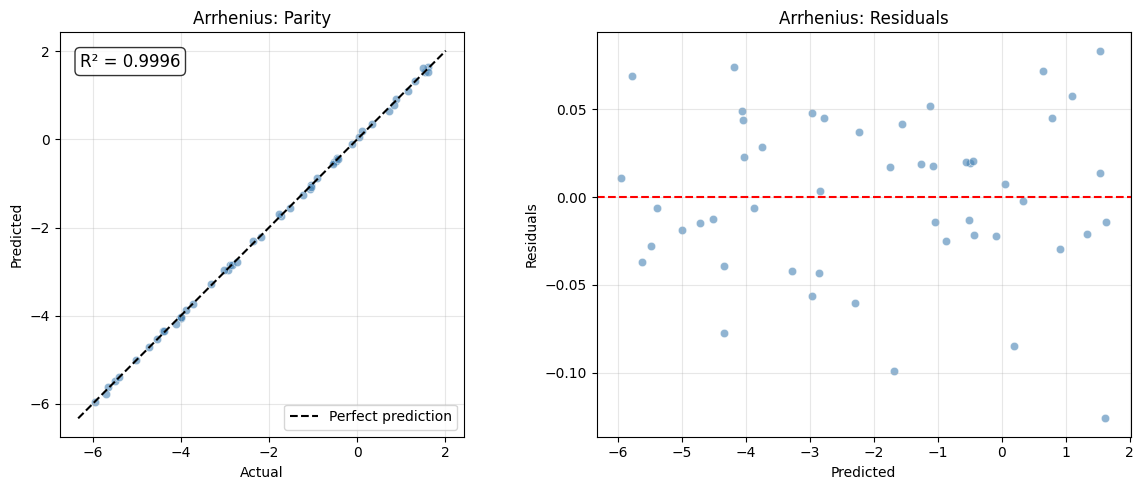


ANOVA Table (Arrhenius)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  1                             1        0.0000        0.0000        0.00      1.0000
  1000/T                        1      259.4556      259.4556   121033.47      0.0000
  Model                         1      259.4556      259.4556   121033.47      0.0000
  Residual                     48        0.1029        0.0021                        
  Total                        49      259.5585        5.2971                        
--------------------------------------------------------------------------------

Variance Contributions:
  1                             0.0%  
  1000/T                      100.0%  ***


In [7]:
# Parameter significance, diagnostics, and ANOVA
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Arrhenius: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Arrhenius: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Arrhenius)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Discover competitive adsorption kinetics.

True model:

$$r = \frac{3.0\,C_A\,C_B}{1 + 0.8\,C_A + 1.5\,C_B}$$

In [8]:
np.random.seed(42)
n_samples = 150

C_A = np.random.uniform(0.1, 2.0, n_samples)
C_B = np.random.uniform(0.1, 2.0, n_samples)

# Kinetic parameters
k = 3.0
K_A = 0.8
K_B = 1.5

r_true = k * C_A * C_B / (1 + K_A * C_A + K_B * C_B)
r = r_true + np.random.randn(n_samples) * 0.03

X = jnp.column_stack([C_A, C_B])
y = jnp.array(r)

print("\nTrue model: r = 3.0*C_A*C_B / (1 + 0.8*C_A + 1.5*C_B)")

# Build comprehensive library
library = (
    BasisLibrary(n_features=2, feature_names=["C_A", "C_B"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_interactions(max_order=2)
    .add_ratios()
)

# Add custom rational functions
library.add_custom(
    name="C_A*C_B/(1+C_A)",
    func=lambda X: X[:, 0] * X[:, 1] / (1 + X[:, 0]),
    complexity=3,
)
library.add_custom(
    name="C_A*C_B/(1+C_B)",
    func=lambda X: X[:, 0] * X[:, 1] / (1 + X[:, 1]),
    complexity=3,
)
library.add_custom(
    name="C_A*C_B/(1+C_A+C_B)",
    func=lambda X: X[:, 0] * X[:, 1] / (1 + X[:, 0] + X[:, 1]),
    complexity=4,
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
)
model.fit(X, y)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print(f"  R² = {model.metrics_['r2']:.4f}")


True model: r = 3.0*C_A*C_B / (1 + 0.8*C_A + 1.5*C_B)



Discovered expression:
  y = 3.393*C_A*C_B/(1+C_A+C_B) - 0.4769*C_A*C_B/(1+C_A) + 0.02057*C_A^2
  R² = 0.9972


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
  C_A*C_B/(1+C_A+C_B)     3.3932    0.0796    42.62   0.00e+00 [3.2359, 3.5506] ***
  C_A*C_B/(1+C_A)    -0.4769    0.0413   -11.54   0.00e+00 [-0.5586, -0.3953] ***
            C_A^2     0.0206    0.0038     5.44   2.15e-07 [0.0131, 0.0280] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


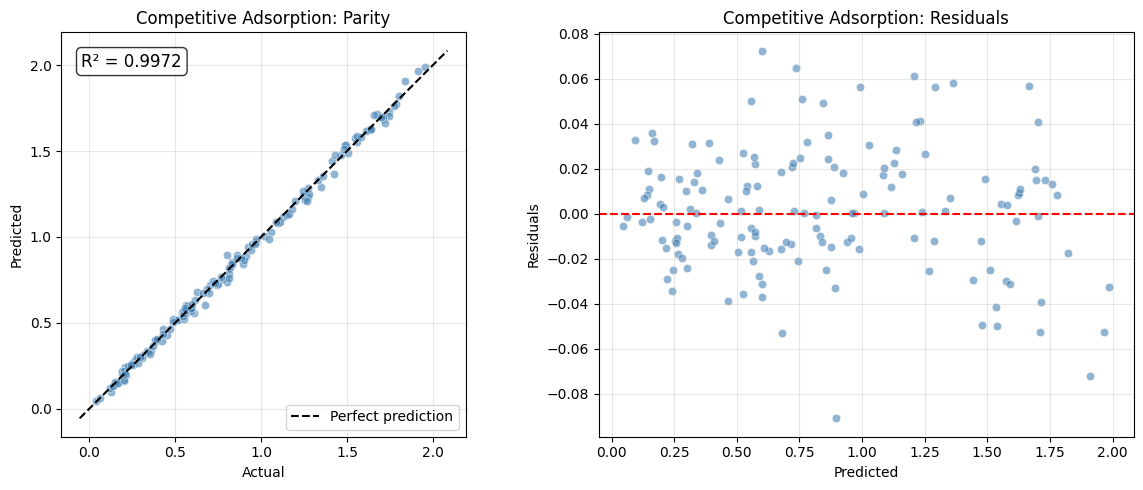


ANOVA Table (Competitive Adsorption)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  C_A*C_B/(1+C_A+C_B)           1       39.0744       39.0744    50947.38      0.0000
  C_A*C_B/(1+C_A)               1        0.4095        0.4095      533.90      0.0000
  C_A^2                         1        0.0227        0.0227       29.62      0.0000
  Model                         2       39.5066       19.7533    25755.45      0.0000
  Residual                    147        0.1127        0.0008                        
  Total                       149       39.6194        0.2659                        
--------------------------------------------------------------------------------

Variance Contributions:
  C_A*C_B/(1+C_A+C_B)          98.9%  ***
  C_A*C_B/(1+C_A)               1.0%  ***
  C_A^2                         0.1%  ***


In [9]:
# Parameter significance, diagnostics, and ANOVA
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Competitive Adsorption: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Competitive Adsorption: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Competitive Adsorption)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")